In [15]:
import xarray as xr

import dask 

from glob import glob 
import os

import numpy as np

import matplotlib.pyplot as plt

import netCDF4 as ncdf

from functools import partial




In [62]:
#--------------------------------------------------
# Local helper functions......

def plotdefs(vlabel, xlabel, ylabel, ylabel2, xrange, yrange, yrange2, scale):
    """
    Simple function to create dictionary for plot info
    """
    return {'vlabel':  vlabel,
            'xlabel':  xlabel, 
            'ylabel':  ylabel, 
            'ylabel2': ylabel2, 
            'xrange':  xrange, 
            'yrange':  yrange,
            'yrange2': yrange2,
            'scale':   scale}

#--------------------------------------------------
def add_fhour(ds):

    filename = ds.encoding["source"].split("_")

    init_time = int(filename[-2])
    fhour     = int(filename[-1][-5:-3])

    ds.coords['fhour'] = fhour
    ds.coords['init_time'] = init_time

    return ds
#--------------------------------------------------
def _add_ens(ds, member=-1):

    print(member)

    ds.coords['ens'] = member

    return ds

#--------------------------------------------------
# example of how to use partial to process mutiple args for preprocess
# https://github.com/pydata/xarray/pull/6825/commits/94b747d963148ac9345a3a2e3d63d8e9410ac3db

# partial_func = partial(_add_ens, member=m)

        # out_array = xr.open_mfdataset(paths, preprocess=_add_ens, combine='nested', concat_dim=['ens'], engine='netcdf4', drop_variables = drop_variables, parallel=True)


#--------------------------------------------------

def read_mfdataset_list(data_dir, pattern):
    """
    Use xarray.open_mfdataset to read multiple netcdf files from a list.
    """
    filelist = os.path.join(data_dir,pattern)
    return xr.open_mfdataset(filelist, preprocess=add_fhour, combine='nested', concat_dim=['fhour'],parallel=True)

#--------------------------------------------------
def list_drop_variables(path, keep_var='PSFC'):

    tmp_ds = xr.open_dataset(path)
    data_vars = tmp_ds.data_vars
    drop_variables = [v for v in data_vars if v != keep_var]
    tmp_ds.close()

    return drop_variables



In [67]:
def plot_dpdt(A, Title=None, plotdefs = None):

    if plotdefs == None:  plotdefs = plotdefs(None, None, None, None, None, None, None)

    Time = np.arange(A.shape[1])

    dadt = A[:,1:] - A[:,:-1]

    shape_A = A.shape

    if A.ndim == 3:
        dadt_mean = dadt.mean(axis=2)
        dadt_var  = dadt.var(axis=2)
    else:
        dadt_mean = dadt.mean(axis=(2,3))
        dadt_var  = dadt.var(axis=(2,3))

    # Figure out which var is being plotted

    # plot code
    fig, ax = plt.subplots(1, 1, layout='constrained')

    twin1 = ax.twinx()

    real_time = 0.5*(Time[1:] + Time[:-1])*300/3600

    if plotdefs['vlabel'] != None: 
        vlabel = plotdefs['vlabel']
    else:
        vlabel = ""

    if plotdefs['scale'] != None: 
        scale = plotdefs['scale']
    else:
        scale = 1.0

    p1, = ax.plot(real_time, dadt_mean.mean(axis=(0))*scale,  color='k', label = f'MEAN {vlabel}')
    p2, = twin1.plot(real_time, dadt_var.var(axis=(0))*scale, color='r', label = f'VAR  {vlabel}')
    
    for x in [1.0,2.0,3.0,4.0,5.0,6.0]:
        ax.axvline(x, 0, 1, linestyle='--', color='k', linewidth=0.5)

    ax.axhline   (0.05, 0, 1, linestyle='--', color='k',  linewidth=0.5)
    ax.axhline   (-0.05, 0, 1, linestyle='--', color='k', linewidth=0.5)
    twin1.axhline(500, 0, 1, linestyle='--', color='r',   linewidth=0.5)

    ax.legend(handles=[p1, p2], loc='upper right')

    if plotdefs['xlabel']  != None: ax.set_xlabel(plotdefs['xlabel'])
    if plotdefs['ylabel']  != None: ax.set_ylabel(plotdefs['ylabel'])
    if plotdefs['ylabel2'] != None: twin1.set(ylabel=plotdefs['ylabel2'])

    if plotdefs['xrange']  != None:  ax.set_xlim(plotdefs['xrange'])
    if plotdefs['yrange']  != None:  ax.set_ylim(plotdefs['yrange'])
    if plotdefs['yrange2'] != None:  twin1.set(ylim=plotdefs['yrange2'])
    
    if Title != None:
        plt.suptitle(Title)
    

In [47]:
# Read data set 

def read_pressure(BASE_PATH, prefix, ens=18, klevel=0, keep_vars='PSFC', model='mpas'):
    
    ens_size = 1 + np.arange(ens)

    for m, i in enumerate(ens_size):   # Collect all file paths for each ensemble member
    
        if model == 'mpas':
            paths = glob(os.path.join(BASE_PATH, f'fcst_{i:02d}', prefix))
        else:
            paths = glob(os.path.join(BASE_PATH, f'ENS_MEM_{i:d}', prefix))
        
        paths.sort()

        if len(paths) == 0:
            print("\n Problem, files are not found, list is empty\n")
            print(os.path.join(BASE_PATH, f'mem{i:02d}', prefix))
            return
    
        if m == 0:  # allocate pressure array from info in ensemble
            
            tmp_ds = xr.open_dataset(paths[0], engine='netcdf4')
            
            data_vars = tmp_ds.data_vars
            drop_variables = [v for v in data_vars if v != keep_vars]
            drop_variables.append('SMCREL')

            if model == 'mpas':
                out_array = np.zeros((ens, len(paths), tmp_ds.nCells.size))
            else:
                out_array = np.zeros((ens, len(paths), tmp_ds.south_north.size, tmp_ds.west_east.size))
            
            tmp_ds.close()

        for n, path in enumerate(paths):
                                 
            df = ncdf.Dataset(paths[n])
            
            if model == 'mpas':
                if df.variables[keep_vars].ndim == 2:
                    out_array[m,n] = df.variables[keep_vars][0,:]
                else:
                    out_array[m,n] = df.variables[keep_vars][0,:,klevel]
            else:
                if df.variables[keep_vars].ndim == 3:
                    out_array[m,n] = df.variables[keep_vars][:,:]
                else:
                    out_array[m,n] = df.variables[keep_vars][0,klevel,:,:]

            if n == 0:  
                print(f" Finished member: {i}, KLEVEL: {klevel} NDIM: {df.variables[keep_vars].ndim: 3}, MEAN: {out_array[m,n].mean()}")

            df.close()

    print( '\n Finished all...\n')

    return out_array
    

In [58]:
BASE_PATH = '/scratch/tajones/dart/FCST/20240508/NODFI/1800'
p1 = read_pressure(BASE_PATH, 'wrfout_d01*', ens=9, keep_vars='P', model='wrf')
#################################################################
BASE_PATH = '/scratch/tajones/dart/FCST/20240508/DFIAF/1800/'
p2 = read_pressure(BASE_PATH, 'wrfout_d01*', ens=9, keep_vars='P', model='wrf')
# # ##################################################################
# BASE_PATH = '/scratch/tajones/dart/FCST/20240508/DFIA2/1800/'
# p3 = read_pressure(BASE_PATH, 'wrfout_d01*', ens=18, model='wrf')
# ##################################################################
# BASE_PATH = '/scratch/tajones/dart/FCST/20240508/DFIA3/1800/'
# p4 = read_pressure(BASE_PATH, 'wrfout_d01*', ens=18, model='wrf')
# ##################################################################
# BASE_PATH = '/scratch/ywang/MPAS/intel/run_dirs/20240508/fcst_project3/1800'
# p3 = read_pressure(BASE_PATH, 'wofs_mpas_*.diag.*nc', ens=18, keep_vars='pressure_p', model='mpas')


 Finished member: 1, KLEVEL: 0 NDIM:   4, MEAN: 496.85474526610903
 Finished member: 2, KLEVEL: 0 NDIM:   4, MEAN: 471.738910627577
 Finished member: 3, KLEVEL: 0 NDIM:   4, MEAN: 432.73261521843807
 Finished member: 4, KLEVEL: 0 NDIM:   4, MEAN: 440.95293695290883
 Finished member: 5, KLEVEL: 0 NDIM:   4, MEAN: 480.1914704913881
 Finished member: 6, KLEVEL: 0 NDIM:   4, MEAN: 475.9489823316786
 Finished member: 7, KLEVEL: 0 NDIM:   4, MEAN: 476.4224735730701
 Finished member: 8, KLEVEL: 0 NDIM:   4, MEAN: 459.46123142784967
 Finished member: 9, KLEVEL: 0 NDIM:   4, MEAN: 493.78914393550025

 Finished all...

 Finished member: 1, KLEVEL: 0 NDIM:   4, MEAN: 466.65846596605513
 Finished member: 2, KLEVEL: 0 NDIM:   4, MEAN: 440.4606159655465
 Finished member: 3, KLEVEL: 0 NDIM:   4, MEAN: 419.9639932735443
 Finished member: 4, KLEVEL: 0 NDIM:   4, MEAN: 415.90343598948584
 Finished member: 5, KLEVEL: 0 NDIM:   4, MEAN: 452.3050610485501
 Finished member: 6, KLEVEL: 0 NDIM:   4, MEAN: 446

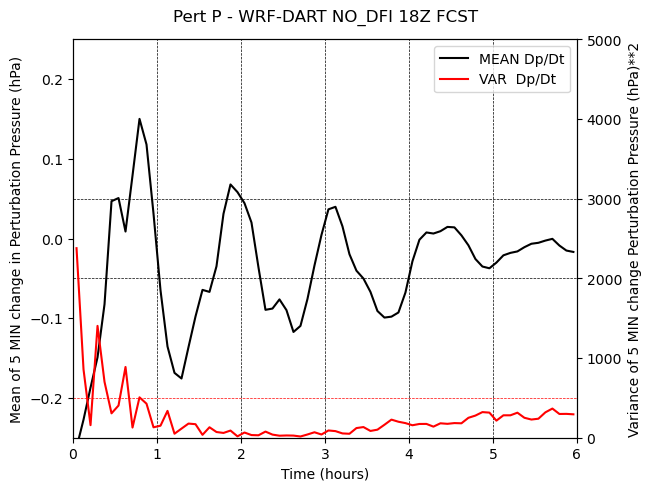

In [68]:
#--------------------------------------------------
p_defs = plotdefs('Dp/Dt',
                  'Time (hours)',
                  'Mean of 5 MIN change in Perturbation Pressure (hPa)',
                  'Variance of 5 MIN change Perturbation Pressure (hPa)**2',
                  (0,6), (-0.25, 0.25), (0.0, 5000.), 0.01, 
                 )

#--------------------------------------------------
plot_dpdt(p1, Title='Pert P - WRF-DART NO_DFI 18Z FCST', plotdefs=p_defs)

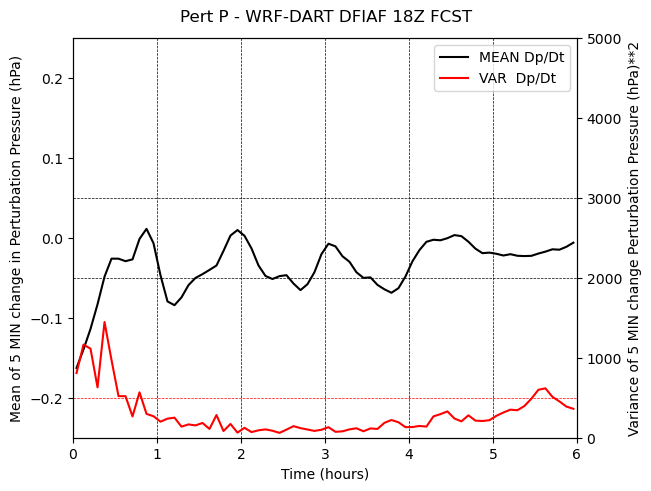

In [70]:
plot_dpdt(p2, Title='Pert P - WRF-DART DFIAF 18Z FCST', plotdefs=p_defs)

(18, 73, 137834)


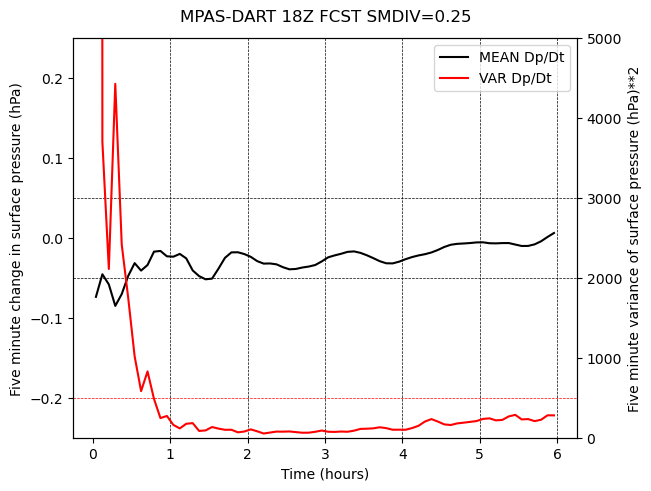

In [41]:
plot_dpdt(p3, Title='MPAS-DART 18Z FCST SMDIV=0.25', variable='P')

In [39]:
# ##################################################################
BASE_PATH = '/scratch/ywang/MPAS/intel/run_dirs/20240508/fcst/1800'
p4 = read_pressure(BASE_PATH, 'wofs_mpas_*.diag.*nc', ens=18, keep_vars='pressure_p', model='mpas')


137834
 Now processing member: 1, NDIM:   3, MEAN: 2003.24462890625
 Now processing member: 2, NDIM:   3, MEAN: 1970.726806640625
 Now processing member: 3, NDIM:   3, MEAN: 1998.0843505859375
 Now processing member: 4, NDIM:   3, MEAN: 1984.85498046875
 Now processing member: 5, NDIM:   3, MEAN: 2003.86181640625
 Now processing member: 6, NDIM:   3, MEAN: 2005.6951904296875
 Now processing member: 7, NDIM:   3, MEAN: 1967.608154296875
 Now processing member: 8, NDIM:   3, MEAN: 1983.2447509765625
 Now processing member: 9, NDIM:   3, MEAN: 2017.8909912109375
 Now processing member: 10, NDIM:   3, MEAN: 1990.247314453125
 Now processing member: 11, NDIM:   3, MEAN: 2022.7265625
 Now processing member: 12, NDIM:   3, MEAN: 1965.188720703125
 Now processing member: 13, NDIM:   3, MEAN: 2012.9622802734375
 Now processing member: 14, NDIM:   3, MEAN: 2003.7548828125
 Now processing member: 15, NDIM:   3, MEAN: 1999.948486328125
 Now processing member: 16, NDIM:   3, MEAN: 1944.4765625
 Now

(18, 73, 137834)


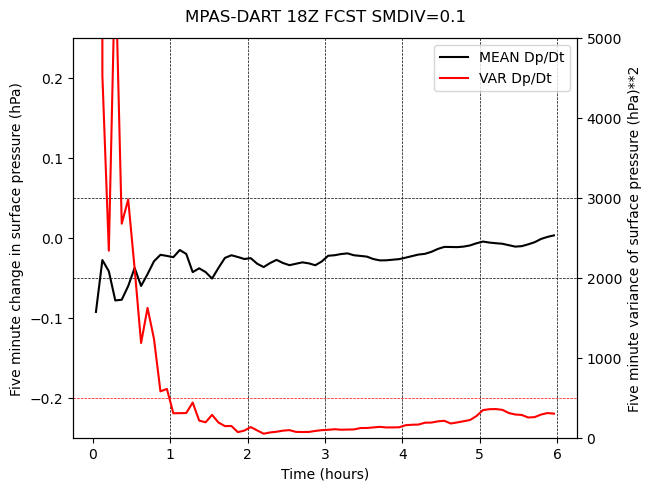

In [42]:
plot_dpdt(p4, Title='MPAS-DART 18Z FCST SMDIV=0.1', variable='Pert P', ylabel0 = )

In [48]:
BASE_PATH = '/scratch/tajones/dart/FCST/20240508/NODFI/1800'
h1 = read_pressure(BASE_PATH, 'wrfout_d01*', ens=18, klevel=1, keep_vars='PH', model='wrf')


 Finished member: 1, KLEVEL: 1 NDIM:   4, MEAN: 9.900150703661971
 Finished member: 2, KLEVEL: 1 NDIM:   4, MEAN: 9.88803804588053
 Finished member: 3, KLEVEL: 1 NDIM:   4, MEAN: 10.000720100108783
 Finished member: 4, KLEVEL: 1 NDIM:   4, MEAN: 9.855226890619596
 Finished member: 5, KLEVEL: 1 NDIM:   4, MEAN: 9.977198357963562
 Finished member: 6, KLEVEL: 1 NDIM:   4, MEAN: 9.993940846663051
 Finished member: 7, KLEVEL: 1 NDIM:   4, MEAN: 9.929593377272289
 Finished member: 8, KLEVEL: 1 NDIM:   4, MEAN: 9.902866064678298
 Finished member: 9, KLEVEL: 1 NDIM:   4, MEAN: 9.973316857745912
 Finished member: 10, KLEVEL: 1 NDIM:   4, MEAN: 9.992127768996026
 Finished member: 11, KLEVEL: 1 NDIM:   4, MEAN: 10.001298003518581
 Finished member: 12, KLEVEL: 1 NDIM:   4, MEAN: 9.91373849524657
 Finished member: 13, KLEVEL: 1 NDIM:   4, MEAN: 10.042438376937973
 Finished member: 14, KLEVEL: 1 NDIM:   4, MEAN: 10.02772735569742
 Finished member: 15, KLEVEL: 1 NDIM:   4, MEAN: 9.923653808886476
 Fi

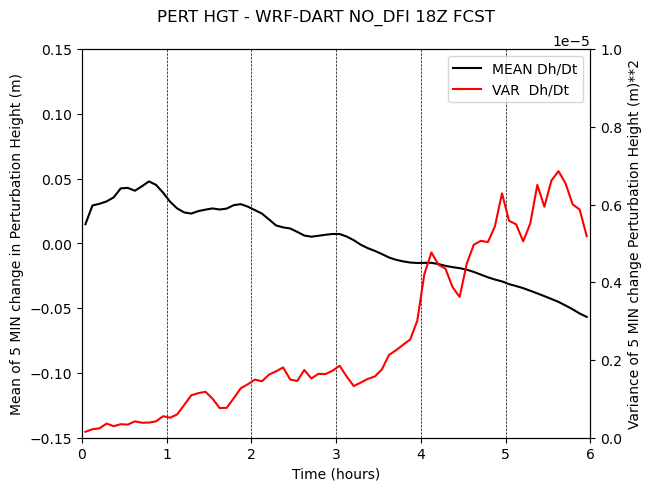

In [55]:
#--------------------------------------------------
h_defs = plotdefs('Dh/Dt',
                  'Time (hours)',
                  'Mean of 5 MIN change in Perturbation Height (m)',
                  'Variance of 5 MIN change Perturbation Height (m)**2',
                  (0,6), (-0.15,0.15), (0.0, 0.00001),
                 )

#--------------------------------------------------
plot_dpdt(h1, Title='PERT HGT - WRF-DART NO_DFI 18Z FCST', plotdefs=h_defs)

In [56]:
#################################################################
BASE_PATH = '/scratch/tajones/dart/FCST/20240508/DFIAF/1800/'
h2 = read_pressure(BASE_PATH, 'wrfout_d01*', ens=18, klevel=1, keep_vars='PH', model='wrf')


 Finished member: 1, KLEVEL: 1 NDIM:   4, MEAN: 10.001289344023334
 Finished member: 2, KLEVEL: 1 NDIM:   4, MEAN: 9.99001249592834
 Finished member: 3, KLEVEL: 1 NDIM:   4, MEAN: 10.11185484662056
 Finished member: 4, KLEVEL: 1 NDIM:   4, MEAN: 9.95537445274459
 Finished member: 5, KLEVEL: 1 NDIM:   4, MEAN: 10.086404581742816
 Finished member: 6, KLEVEL: 1 NDIM:   4, MEAN: 10.099029905136426
 Finished member: 7, KLEVEL: 1 NDIM:   4, MEAN: 10.024355489076509
 Finished member: 8, KLEVEL: 1 NDIM:   4, MEAN: 9.993279163191053
 Finished member: 9, KLEVEL: 1 NDIM:   4, MEAN: 10.083933502296606
 Finished member: 10, KLEVEL: 1 NDIM:   4, MEAN: 10.0968698883507
 Finished member: 11, KLEVEL: 1 NDIM:   4, MEAN: 10.10964952725437
 Finished member: 12, KLEVEL: 1 NDIM:   4, MEAN: 10.009960932121013
 Finished member: 13, KLEVEL: 1 NDIM:   4, MEAN: 10.155447049812476
 Finished member: 14, KLEVEL: 1 NDIM:   4, MEAN: 10.147586790612008
 Finished member: 15, KLEVEL: 1 NDIM:   4, MEAN: 10.0315000352131


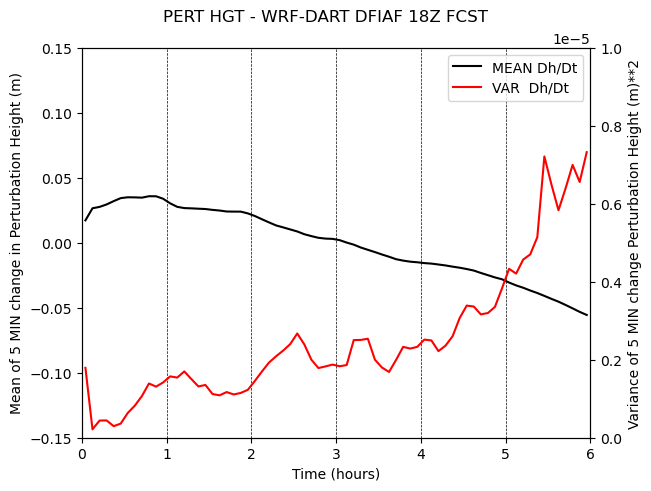

In [57]:
#--------------------------------------------------
h_defs = plotdefs('Dh/Dt',
                  'Time (hours)',
                  'Mean of 5 MIN change in Perturbation Height (m)',
                  'Variance of 5 MIN change Perturbation Height (m)**2',
                  (0,6), (-0.15,0.15), (0.0, 0.00001),
                 )

#--------------------------------------------------
plot_dpdt(h2, Title='PERT HGT - WRF-DART DFIAF 18Z FCST', plotdefs=h_defs)